# COGS 108 - Predicting an App's User Rating

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [ X ] YES - make available
* [  ] NO - keep private

## Video

Video: https://drive.google.com/file/d/1AgwnJC5eowWr6rNY346gU4_Cuzn5mqVi/view?usp=sharing

# Overview

In our project, we hope to discover what metrics an app on the Apple app store have that correlate the most with having a high user rating. We then hope to be able to predict an app's user rating based on these features. 

We will be performing data analysis on a dataset of 7200 apps from the Apple app store with metrics such as genre, price, and description. By plotting the correlation between these metrics and user rating, we hope to visualize the effect that these metrics have on user rating and then use these qualitative findings alongside quantitative metrics from pairwise correlation functions to choose the best features for our prediction model. We will then create the prediction model using logistic regression and analyze the model to see if it can accurately predict an app's user rating based on the metrics given.

# Names

- Bryce Pollack
- Siddhant Bhagat
- Anthony Li
- Christine Sanchez

<a id='research_question'></a>
# Research Question

Can an Apple App Store app's average user rating (a metric out of 5 stars tracked by the app store and included in our dataset) be predicted from other metrics stored in the app store about the app, such as genre, app description, or price?

<a id='background'></a>

## Background & Prior Work

Mobile app stores, such as the Apple App Store and Google Play Store, have become a significant part of our daily lives. With millions of apps available on both platforms, it is crucial to understand how to identify the most popular and highly-rated apps. One way to do this is to use app store metrics, which are numerical indicators that describe an app's performance, such as the number of downloads, user ratings, reviews etc.

Several studies have been conducted to analyze the features and characteristics of successful mobile apps. For example, a study by Precious Chima$^{(1)}$ at New York University on apple app store found that app size, update frequency, and user ratings are essential factors that contribute to an app's success, concluding that gaming appeared to be the most prominent category amongst all applications in the app store, suggesting that it is most likely, the category with the highest money-potential to be made. Another study conducted by Yulia Norenko$^{(2)}$ at New York University on google play store and found that app category, user ratings, and reviews are significant factors that affect an app's downloads and its state in the market.

Most previous research has focused on the relationship between individual app store metrics and an app's performance, rather than the accuracy of predicting an app's average user rating using a combination of these metrics. Therefore, this study aims to investigate which app store metrics from both the Apple App Store and Google Play Store can be used to accurately predict an app's average user rating.

The resources used for this study is the Apple App Store and Google Play Store data set available on Kaggle$^{(3)}$. This data set contains information on over 10,000 apps, including app name, category, price, user ratings, and reviews. The author of this post, from which we got the datasets from, used the dataset to analyze the ease with which a developer's app can be found on the store to maximize downloads

1. https://nycdatascience.com/blog/student-works/web-scraping-apples-app-store/
2. https://nycdatascience.com/blog/student-works/web-scraping/analysis-of-apps-in-the-google-play-store/
3. https://www.kaggle.com/datasets/ramamet4/app-store-apple-data-set-10k-apps

# Hypothesis


We hypothesize that the sentiment of the app's description and the price of the app (it being low/free) will be the most important metrics in predicting an app's average use rating. The app's description can have a huge impact on what the user expects out of the app based on the promises it makes to the user/tone it speaks to the user in, and if a user doesn't spend money on an app they are less likely to feel the need to tell the world why the app was bad thus lowering the number of negative ratings.

# Dataset(s)

- Dataset Name: Mobile App Store ( 7200 apps)
- Link to the dataset: https://www.kaggle.com/datasets/ramamet4/app-store-apple-data-set-10k-apps?resource=download&select=appleStore_description.csv
- Number of observations: 7197

This dataset is split into 2 sections: app store metrics (in AppleStore.csv) and app descriptions (in appleStore_description.csv). We merged these two sections together to form one dataset. This dataset has 7197 observations with each observation corresponding to a different app on the Apple App Store. There are 17 total columns in this merged dataset, with columns of particular interest including app name, size in bytes, price, average user rating, genre, and description. 

# Setup

In [1]:
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

# scikit-learn imports
#   TF-IDF Vectorizer that first removes widely used words in the dataset and then transforms test data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# import re for regular expression
import re

## seaborn for plotting
import seaborn as sns
sns.set(font_scale=1.2, style="white")

import patsy
import statsmodels.api as sm

# import matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (12, 5)

from collections import defaultdict
import string


[nltk_data] Downloading package punkt to /Users/bryce/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/bryce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# import both app page information along with description of app
apps = pd.read_csv('AppleStore.csv')
descriptions = pd.read_csv('appleStore_description.csv')

# Data Cleaning

First, we want to merge both dataframes

In [3]:
merged = apps.merge(descriptions,left_on='id',right_on='id')
merged.head(3)

,Unnamed: 0,id,track_name_x,size_bytes_x,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,track_name_y,size_bytes_y,app_desc
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1,PAC-MAN Premium,100788224,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1,Evernote - stay organized,158578688,Let Evernote change the way you organize your ...
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,Download the most popular free weather app pow...


In [4]:
# currency only has 'USD'
merged.currency.value_counts()

USD    7197
Name: currency, dtype: int64

After merging, we see that it includes duplicate columns that both datasets have. We will drop those and also get rid of columns that are unnecessary for helping up with our research question.

Here are the columns that we've decided to remove (besides the duplicates and the unknown index columns):

**`ver`**: This represents the current version of the app, which will not be useful in helping us predict overall user rating.

**`currency`**: This column contains only 'USD' throughout the entire dataframe. Since all observations have the same value for this column, it will not be useful for our research question.

**`vpp_lic`**: This represents if Vpp Device Based Licensing is enabled for the app. This metric only applies to enterprise customers (volume purchasing licensing gives enterprises certain privileges) and is unlikely to affect user rating.

In [5]:
merged = merged.drop(['track_name_y','size_bytes_y','Unnamed: 0','ver','currency','vpp_lic'],axis=1)
merged.head(3)

,id,track_name_x,size_bytes_x,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,app_desc
0,281656475,PAC-MAN Premium,100788224,3.99,21292,26,4.0,4.5,4+,Games,38,5,10,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,158578688,0.00,161065,26,4.0,3.5,4+,Productivity,37,5,23,Let Evernote change the way you organize your ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,2822,3.5,4.5,4+,Weather,37,5,3,Download the most popular free weather app pow...


The current state of the dataset has uninformative column names. In this step, we'll rename the columns based off of these descriptions given:

"id" : App ID

"track_name_x": App Name

"size_bytes_x": Size (in Bytes)

"price": Price amount

"rating_count_tot": User Rating counts (for all version)

"rating_count_ver": User Rating counts (for current version)

"user_rating" : Average User Rating value (for all version)

"user_rating_ver": Average User Rating value (for current version)

"cont_rating": Content Rating

"prime_genre": Primary Genre

"sup_devices.num": Number of supporting devices

"ipadSc_urls.num": Number of screenshots showed for display

"lang.num": Number of supported languages

"app_desc": Description of app

In [6]:
# new column names
new_cols = ['id','app_name','size_bytes','price','total_num_rating','ver_num_rating','user_rating','ver_user_rating','content_rating','genre','num_device_supported','num_screenshots','num_language_supp','description']

In [7]:
# set old column names to new ones created above
merged.columns = new_cols
merged.head(3)

,id,app_name,size_bytes,price,total_num_rating,ver_num_rating,user_rating,ver_user_rating,content_rating,genre,num_device_supported,num_screenshots,num_language_supp,description
0,281656475,PAC-MAN Premium,100788224,3.99,21292,26,4.0,4.5,4+,Games,38,5,10,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,158578688,0.00,161065,26,4.0,3.5,4+,Productivity,37,5,23,Let Evernote change the way you organize your ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,2822,3.5,4.5,4+,Weather,37,5,3,Download the most popular free weather app pow...


Let's check if we have any null values throughout the dataframe that we have to remove.

In [8]:
# there are none, so we don't have to deal with any null values
merged.isna().sum()

id                      0
app_name                0
size_bytes              0
price                   0
total_num_rating        0
ver_num_rating          0
user_rating             0
ver_user_rating         0
content_rating          0
genre                   0
num_device_supported    0
num_screenshots         0
num_language_supp       0
description             0
dtype: int64

In this step, lets see if the data types match up to each column and if we need to rework any columns.

In [9]:
# everything checks out. every column is already the data type it should be
merged.dtypes

id                        int64
app_name                 object
size_bytes                int64
price                   float64
total_num_rating          int64
ver_num_rating            int64
user_rating             float64
ver_user_rating         float64
content_rating           object
genre                    object
num_device_supported      int64
num_screenshots           int64
num_language_supp         int64
description              object
dtype: object

In our last step, we'll look at the description to see if we can clean up the text for usage in future natural language processing.

Going through some of the descriptions, we can see that the text is littered with "\n". This may hinder us in doing natural language processing since words with "\n" can we considered different words than without the "\n".

In [10]:
merged.description.iloc[0]

'SAVE 20%, now only $3.99 for a limited time!\n\nOne of the most popular video games in arcade history!\n2015 World Video Game Hall of Fame Inductee\n\nWho can forget the countless hours and quarters spent outrunning pesky ghosts and chompin’ on dots? Now you can have the same arcade excitement on your mobile devices! \nGuide PAC-MAN through the mazes with easy swipe controls, a MFi controller, or kick it old school with the onscreen joystick!\nEat all of the dots to advance to the next stage. Go for high scores and higher levels! Gain an extra life at 10.000 points! Gobble Power Pellets to weaken ghosts temporarily and eat them up before they change back. Avoid Blinky, the leader of the ghosts, and his fellow ghosts Pinky, Inky, and Clyde, or you will lose a life. It’s game over when you lose all your lives.\n\n9 NEW MAZES Included!!!\nThe game includes 9 new mazes in addition to the pixel for pixel recreation of the classic original maze. Challenge your skill to beat them all! We are

In [11]:
# compared to the previous description, all \n were replaced with a space and also we got rid of extra spaces
merged.description = merged.description.str.replace('\n', ' ').replace(r'\s+', ' ', regex=True)
merged.description[0]

'SAVE 20%, now only $3.99 for a limited time! One of the most popular video games in arcade history! 2015 World Video Game Hall of Fame Inductee Who can forget the countless hours and quarters spent outrunning pesky ghosts and chompin’ on dots? Now you can have the same arcade excitement on your mobile devices! Guide PAC-MAN through the mazes with easy swipe controls, a MFi controller, or kick it old school with the onscreen joystick! Eat all of the dots to advance to the next stage. Go for high scores and higher levels! Gain an extra life at 10.000 points! Gobble Power Pellets to weaken ghosts temporarily and eat them up before they change back. Avoid Blinky, the leader of the ghosts, and his fellow ghosts Pinky, Inky, and Clyde, or you will lose a life. It’s game over when you lose all your lives. 9 NEW MAZES Included!!! The game includes 9 new mazes in addition to the pixel for pixel recreation of the classic original maze. Challenge your skill to beat them all! We are constantly up

In [12]:
#Remove all apps with 0 user ratings
merged = merged[merged['total_num_rating'] > 0]

# Data Analysis & Results

## Visualizing frequency of user ratings

First, let's visualize the distribution of user ratings.

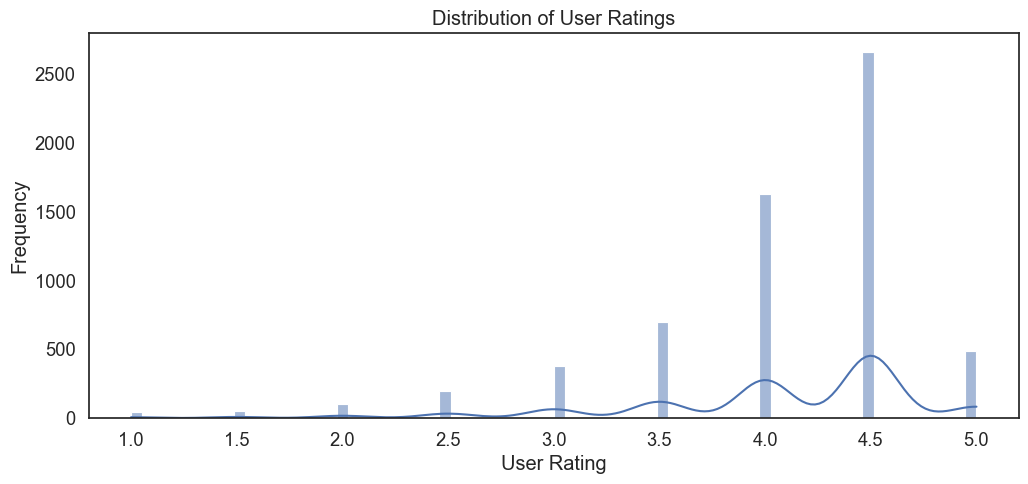

In [13]:
# Plot the distribution of user ratings
sns.histplot(merged['user_rating'], kde=True)

# Set labels and title for the plot
plt.xlabel('User Rating')
plt.ylabel('Frequency')
plt.title('Distribution of User Ratings')

# Display the plot
plt.show()

From this, we can see that the an app's rating is highly skewed towards 4.5 out of 5 stars.

Now let's look at a table view of the data:

For each column/metric with strictly numerical values, how does the average of that metric correlate with user rating?

In [14]:
merged.groupby('user_rating').mean()

/var/folders/s3/ysbk70f526qcnsvlwdz95x5c0000gn/T/ipykernel_18916/4058136017.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged.groupby('user_rating').mean()


,id,size_bytes,price,total_num_rating,ver_num_rating,ver_user_rating,num_device_supported,num_screenshots,num_language_supp
user_rating,,,,,,,,,
1.0,9.665681e+08,6.311240e+07,1.926591,29.568182,17.204545,0.977273,38.045455,2.477273,2.727273
1.5,9.566616e+08,6.397966e+07,1.208929,203.500000,22.482143,1.250000,37.803571,2.196429,2.232143
2.0,9.042506e+08,8.878507e+07,1.155755,2907.235849,62.075472,1.985849,37.264151,2.915094,2.915094
2.5,8.457130e+08,1.238298e+08,1.103214,5419.933673,50.530612,2.293367,36.413265,2.918367,4.545918
3.0,8.418089e+08,1.694169e+08,1.288068,7487.130548,234.926893,2.647520,36.668407,3.138381,4.057441
3.5,8.087262e+08,2.044705e+08,1.757436,15503.266382,138.287749,3.158120,36.797721,3.658120,5.777778
4.0,8.332178e+08,2.383879e+08,2.209865,7836.835793,301.084256,3.736777,37.263838,4.031365,5.911439
4.5,8.330329e+08,2.163224e+08,1.802110,22029.743522,803.062336,4.199024,37.434848,4.136688,6.741645
5.0,9.249921e+08,1.574089e+08,1.645589,12699.829268,974.873984,4.378049,37.617886,3.713415,4.674797


From this table, it's difficult to visualize any concrete patterns. It appears that, generally speaking, as average size in bytes, price, total number of ratings, etc. for all numerical metrics gets larger, so does the app's user rating. Let's further explore this pattern by looking at the relationship between these metrics and user rating.

## Plotting relationship between app size and user rating

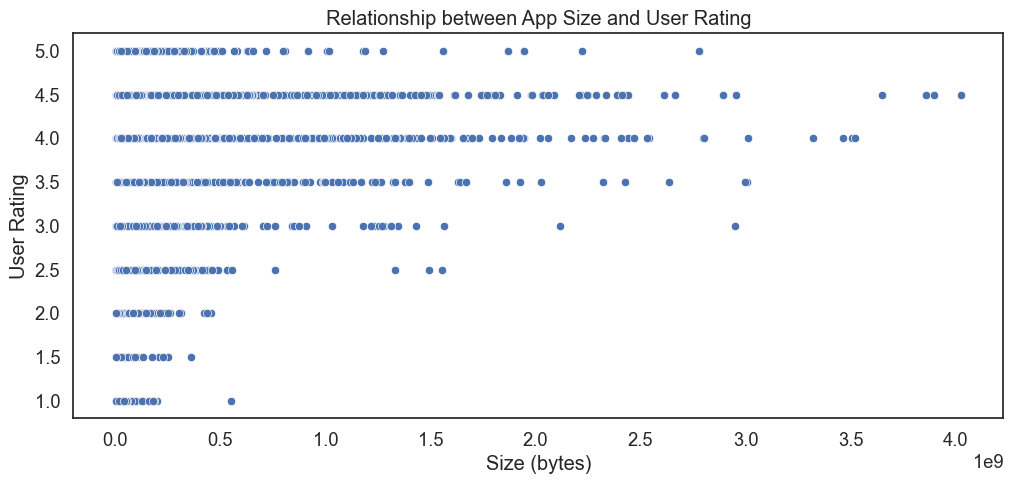

In [15]:
sns.scatterplot(x='size_bytes', y='user_rating', data=merged)

# Set labels and title for the plot
plt.xlabel('Size (bytes)')
plt.ylabel('User Rating')
plt.title('Relationship between App Size and User Rating')

# Display the plot
plt.show()

Here, we are plotting the size of the app versus the user rating to see if a correlation exists between the two. From this graph, it appears that as the app grows in size, the user ratings approach and peak at 4.5. This follows the true data which also has most of its user ratings at around 4.5, therefore there is a comparatively small correlation.

## Plotting relationship between price and user rating

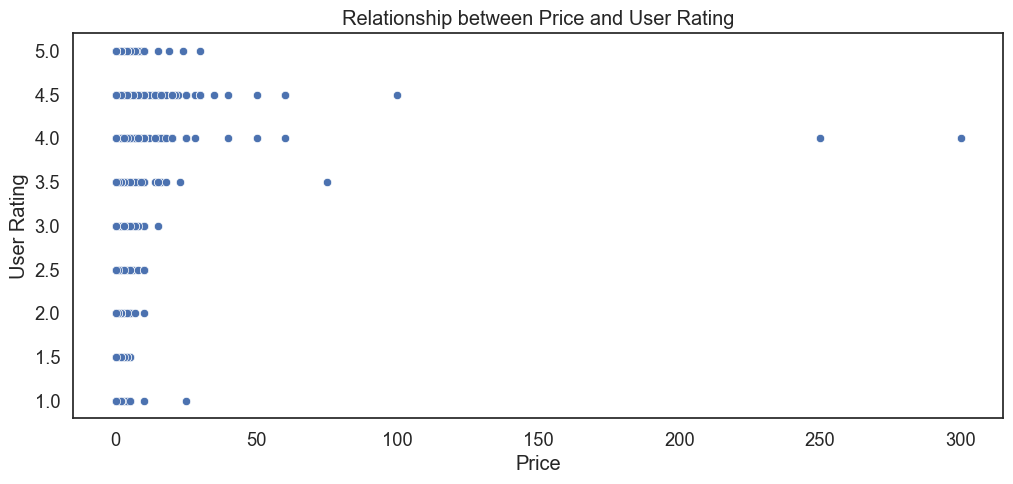

In [16]:
sns.scatterplot(x='price', y='user_rating', data=merged)

# Set labels and title for the plot
plt.xlabel('Price')
plt.ylabel('User Rating')
plt.title('Relationship between Price and User Rating')

# Display the plot
plt.show()

Here, we are plotting the price of the app versus the user rating to see if a correlation exists between the two. From this graph, it appears that as the price grows, the user ratings approach and peak at 4.0. This is somewhat close to the true data which also has most of its user ratings at around 4.5, therefore there is a comparatively small correlation.

## Plotting relationship between total number of user ratings and user rating

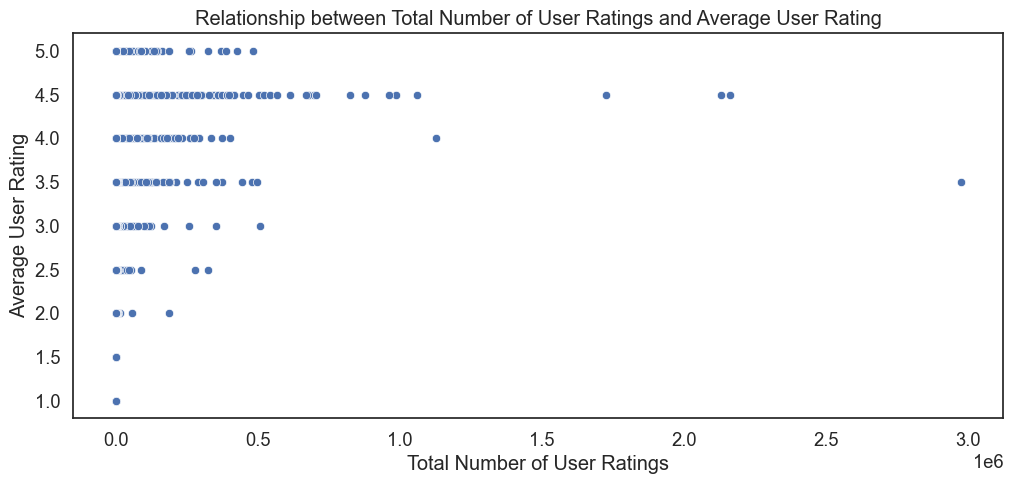

In [17]:
sns.scatterplot(x='total_num_rating', y='user_rating', data=merged)

# Set labels and title for the plot
plt.xlabel('Total Number of User Ratings')
plt.ylabel('Average User Rating')
plt.title('Relationship between Total Number of User Ratings and Average User Rating')

# Display the plot
plt.show()

Here, we are plotting the total number of user ratings versus the user rating to see if a correlation exists between the two. From this graph, it appears that as the total number of user ratings grows, the user ratings approach and peak at 3.5 before dropping off. This does not provide a clear correlation between the two variables.

## Plotting relationship between number of user ratings for current version of app and user rating

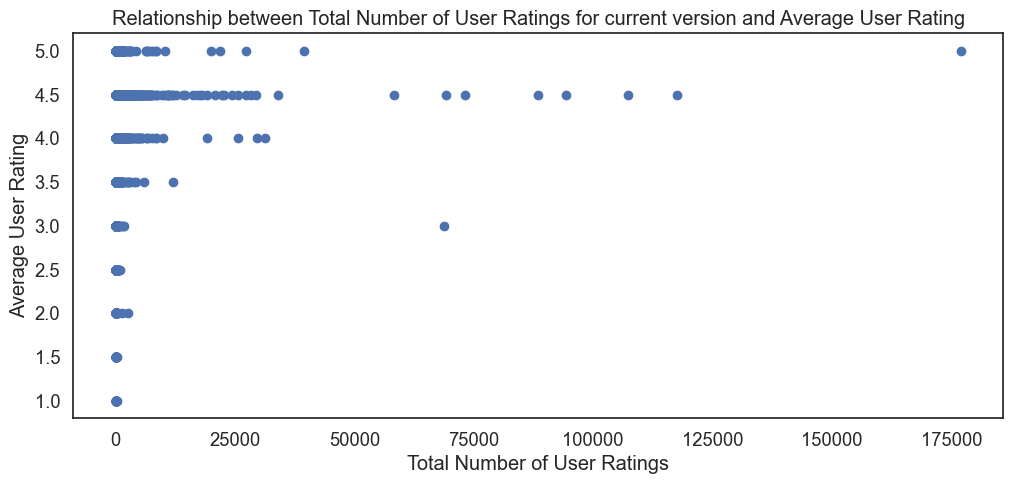

In [18]:
plt.scatter(merged['ver_num_rating'], merged['user_rating'])

# Set labels and title for the plot
plt.xlabel('Total Number of User Ratings')
plt.ylabel('Average User Rating')
plt.title('Relationship between Total Number of User Ratings for current version and Average User Rating')

# Display the plot
plt.show()

Here, we are plotting the total number of user ratings for the current version versus the user rating to see if a correlation exists between the two. From this graph, it appears that as the total number of user ratings grows, the user ratings grow. However, the total number of user ratings for the current version seem to be grouped around 0-25000. Therefore, no correlation between the two can be drawn.

## Plotting relationship between number of devices supported and user rating

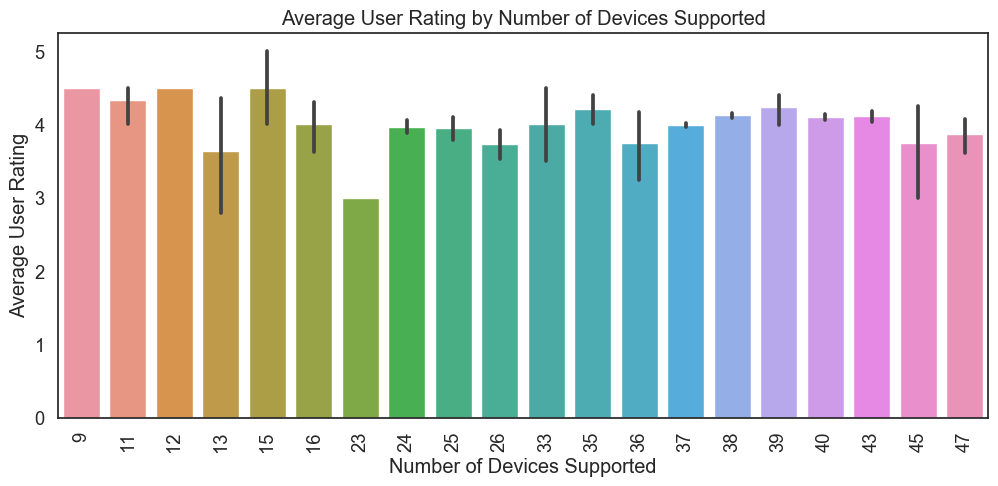

In [19]:
sns.barplot(x='num_device_supported', y='user_rating', data=merged)

# Set labels and title for the plot
plt.xlabel('Number of Devices Supported')
plt.ylabel('Average User Rating')
plt.title('Average User Rating by Number of Devices Supported')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

Here, we are plotting the number of devices supported versus the user rating to see if a correlation exists between the two. From this graph, it appears there is no correlation between the two as the graph rise and fall at random.

## Plotting relationship between number of screenshots previewed and user rating

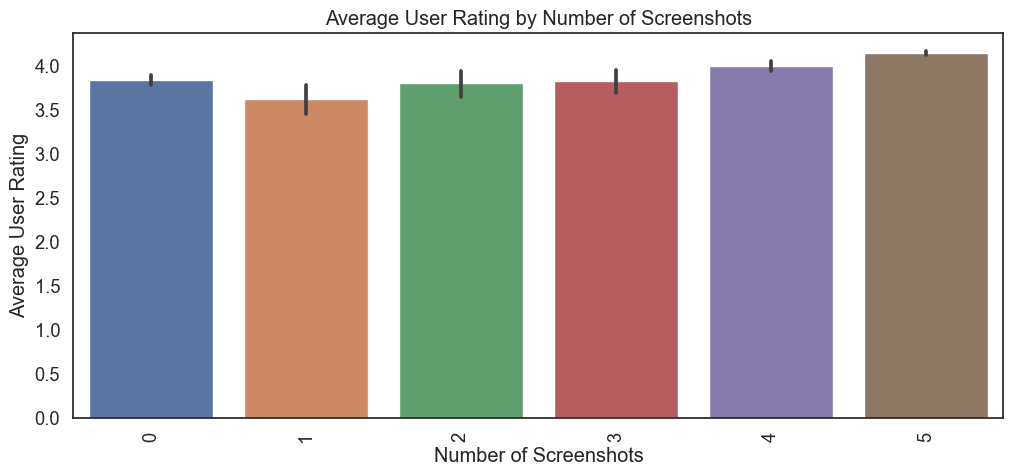

In [20]:
sns.barplot(x='num_screenshots', y='user_rating', data=merged)

# Set labels and title for the plot
plt.xlabel('Number of Screenshots')
plt.ylabel('Average User Rating')
plt.title('Average User Rating by Number of Screenshots')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

Here, we are plotting the total number of screenshots versus the user rating to see if a correlation exists between the two. From this graph, it appears that as the number of screenshots grows, the user ratings grow as well with an outlier at 0 screenshots. Therefore, a small correlation between the two can be seen.

## Plotting relationship between number of languages supported and user rating

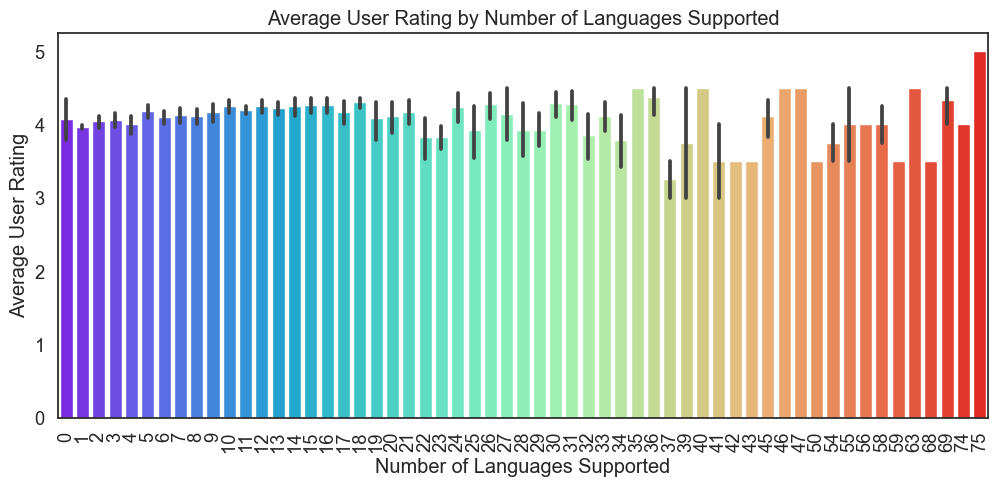

In [21]:
sns.barplot(x='num_language_supp', y='user_rating', data=merged, palette='rainbow')

# Set labels and title for the plot
plt.xlabel('Number of Languages Supported')
plt.ylabel('Average User Rating')
plt.title('Average User Rating by Number of Languages Supported')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

Here, we are plotting the number of languages supported versus the user rating to see if a correlation exists between the two. From this graph, it appears that as the number of supported languages grows, the user ratings grow as well. However, there are too many outliers (especially as it reaches 75 languages supported) so no correlation can be drawn between the two.

## Plotting relationship between genre and user rating

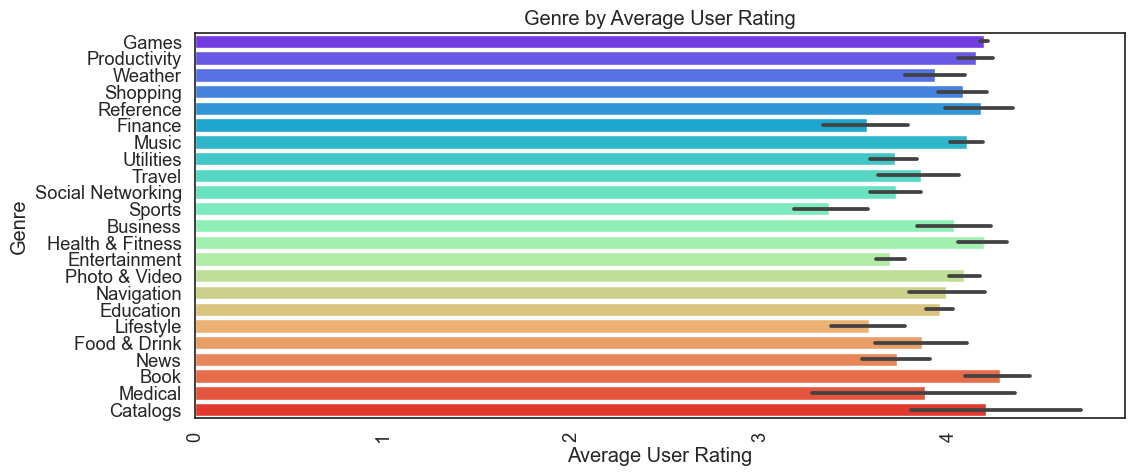

In [22]:
sns.barplot(x='user_rating',y='genre',data=merged, palette='rainbow')

# Set labels and title for the plot
plt.xlabel('Average User Rating')
plt.ylabel('Genre')
plt.title('Genre by Average User Rating')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

Here, we are plotting the genre versus the user rating to see if a correlation exists between the two. From this graph, it appears that there are certain genres, such as Book, Catalogs, and Health & Fitness, that have much higher user ratings than the others. Therefore, these two variables seem to be related.

In [23]:
# Calculate the average user rating and count for each genre
genre_stats = merged.groupby('genre')['user_rating'].agg(['mean', 'count'])

# Rename the columns
genre_stats.columns = ['average_user_rating', 'count']

# Reset the index to make 'genre' a column
genre_stats = genre_stats.reset_index()

# Sort the dataframe by user rating in ascending order
sorted_genre_stats = genre_stats.sort_values(by='average_user_rating')

# Print the sorted dataframe
print(sorted_genre_stats)

                genre  average_user_rating  count
19             Sports             3.366337    101
5             Finance             3.563380     71
9           Lifestyle             3.575221    113
4       Entertainment             3.687898    471
21          Utilities             3.712329    219
18  Social Networking             3.720149    134
13               News             3.725000     60
20             Travel             3.852113     71
6        Food & Drink             3.855769     52
10            Medical             3.875000     20
22            Weather             3.924242     66
3           Education             3.952196    387
12         Navigation             3.983871     31
1            Business             4.028302     53
17           Shopping             4.075472    106
14      Photo & Video             4.081538    325
11              Music             4.097015    134
15       Productivity             4.145349    172
16          Reference             4.169811     53


## Plotting relationship between description length and user rating

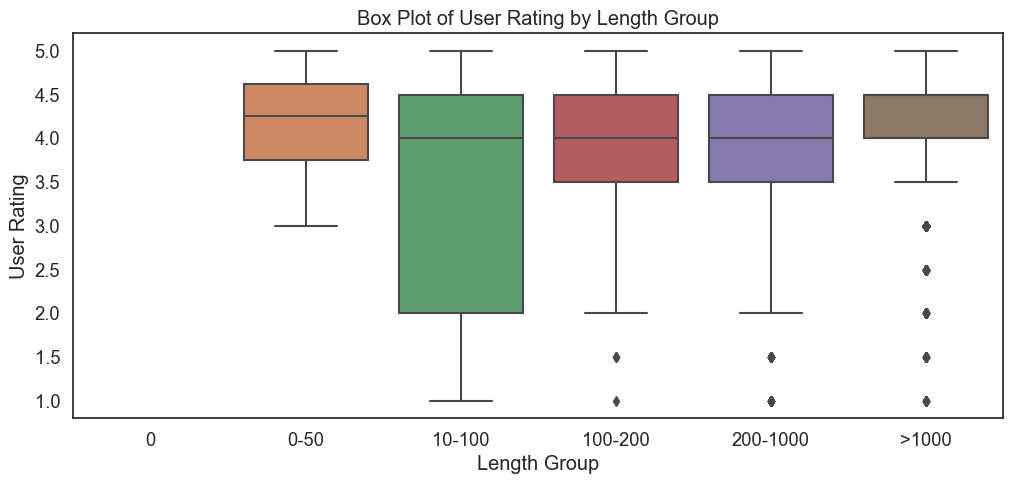

In [24]:
merged = merged.assign(description_length = merged['description'].apply(len))
# Define the length groups
bins = [-0.01, 0.01, 50, 100, 200, 1000, float('inf')]
labels = ['0', '0-50', '10-100', '100-200', '200-1000', '>1000']

# Group the elements based on length
merged['length_group'] = pd.cut(merged['description_length'], bins=bins, labels=labels, right=False)

# Generate the box plot with the updated price groups
sns.boxplot(x='length_group', y='user_rating', data=merged)
plt.xlabel('Length Group')
plt.ylabel('User Rating')
plt.title('Box Plot of User Rating by Length Group')
plt.show()

Here, we are plotting the description length versus the user rating to see if a correlation exists between the two. From this graph, it appears that descriptions of length 10-100 characters have a much wider range of user ratings, while descriptions of length >1000 characters are more localized around higher user ratings. Therefore, description length seems to have somewhat of a correlation with user rating.

## Correlations

In [25]:
correlations = merged.corr(numeric_only=True)['user_rating'].drop('user_rating')
sorted_correlations = correlations.abs().sort_values(ascending=False)
top_correlations = sorted_correlations.head(5)
print(top_correlations)

ver_user_rating       0.480029
num_screenshots       0.178877
description_length    0.111367
num_language_supp     0.086507
ver_num_rating        0.063408
Name: user_rating, dtype: float64


From this, it appears that there are no strong correlations between any of the metrics and user rating. The user rating of the app's current version and overall user rating have a somewhat strong correlation, which is to be expected and not very helpful for creating a prediction model. The genre of the app could be a useful predictor, as certain genres have much higher average user ratings than others.

Now let's look at the description to see if any useful patterns can be found from that information.

## Description Analysis

First, we need to clean the descriptions by making them all lowercase and removing and special characters/punctuation, then using the stopwords package to remove all stopwords in the English language.

In [26]:
merged['description'] = merged['description'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex=True)

In [27]:
stopwords_list = stopwords.words('english')

filtered_descriptions = []

for description in merged['description'].tolist():
    # Tokenize the description into individual words
    words = nltk.word_tokenize(description)
    
    # Remove stopwords from the words list
    filtered_words = [word for word in words if word not in stopwords_list]
    
    # Join the filtered words back into a sentence
    filtered_description = ' '.join(filtered_words)
    
    # Add the filtered description to the filtered_descriptions list
    filtered_descriptions.append(filtered_description)



Now that the descriptions have been cleaned, we can vectorize them for TF-IDF analysis.

In [28]:
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', tokenizer=word_tokenize, stop_words=stopwords.words("english"))
tfidf_matrix = tfidf.fit_transform(filtered_descriptions)
desc_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

most_unique = desc_tfidf.idxmax(axis=1).tolist()
most_uniques = [*set(most_unique)]

/Users/bryce/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryce/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


most_uniques now stores the TF-IDF for the top words in our corpus. We can convert these back to words and calculate their correlation with user rating using the corrwith function.

In [29]:
word_list = most_uniques

# Create feature matrix
vectorizer = CountVectorizer(vocabulary=word_list)
feature_matrix = vectorizer.fit_transform(filtered_descriptions)

# Convert feature matrix to dataframe
feature_df = pd.DataFrame(feature_matrix.toarray(), columns=word_list)


# Calculate correlation with user_rating
correlations = feature_df.corrwith(merged['user_rating']).sort_values(ascending=False)

# Print correlations
print(correlations)

platforms     0.038704
abyss         0.035890
child         0.033525
birthday      0.033218
either        0.032545
                ...   
scotmoji           NaN
9                  NaN
moats              NaN
fleamarket         NaN
bleach             NaN
Length: 4558, dtype: float64


As we can see, all of these unique words have <0.1 correlation with user rating. Therefore, it is difficult to pinpoint any specific words that have a correlation with user rating.

In conclusion, it's hard to immediately spot any patterns given the EDA that we have done. As previously mentioned, the user rating of the app's current version and overall user rating have a somewhat strong correlation, which is to be expected and not very helpful for creating a prediction model, and the genre of the app has the potential to be a useful predictor, as certain genres have much higher average user ratings than others. This is likely due to the skewed distribution of user ratings, with the vast majority being around 4.5 out of 5 stars. 

## Prediction Model

### Baseline Model

First, we set a baseline model of predicting the most common average user rating for all data points. We yield a accuracy of 0.425. This helps us set an accuracy threshold for our final prediction model.

In [30]:
np.mean(merged.user_rating == 4.5)

0.42485641352903636

### Hypothesis Model

Let's first create a feature vector for a prediction model based on our hypothesis. To reiterate, We hypothesized that the sentiment of the app's description and the price of the app (it being low/free) will be the most important metrics in predicting an app's average user rating.

In [31]:
import math
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder

Here, we will create one hot encoding for both if the price is low (3.99 or less) or high (3.99 and above) and also create a function to create a feature vector that includes bag of words (the number of counts in the top 1000 words), tfidf, and price.

In [32]:
merged['low_price'] = merged.price <= 3.99
merged['high_price'] = merged.price > 3.99

In [33]:
def feature(datum):
    feat = [0] * len(words)
    res = ''.join([i for i in datum['description'].lower() if not i in punctuation])
    
    # bag of words
    for word in res.split():
        if word in words:
            feat[wordID[word]] += 1
            
            
    # tfidf
    
    tf = defaultdict(int)
    r = ''.join([c for c in datum['description'].lower() if not c in punctuation])
    for word in r.split():
        tf[word] = 1
        
    tfidf = dict(zip(words, [tf[w] * math.log2(len(merged) / docfreq[w]) for w in words]))
    tfidfQuery = [tf[w] * math.log2(len(merged) / docfreq[w]) for w in words]
    
    # price
    low_price = [datum['low_price']]
    high_price = [datum['high_price']]
    
    return feat + tfidfQuery + low_price + high_price + [1]

In order to get these features, we will create the word counts and also the document frequency

In [34]:
# here, we create a count of every word in all descriptions
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for row in merged['description']:
    for word in row.split():
        word = ''.join([char for char in word.lower() if char not in punctuation])
        wordCount[word] += 1

# get the top 1000 words and we'll use this as a feature      
counts = (sorted(wordCount.items(), key=lambda x: x[1], reverse=True))
counts = [(freq,word) for word, freq in counts if word not in stopwords.words('English') and word != '']
top_n = 1000
words = {word: freq for freq, word in counts[:top_n]}

# document frequency
docfreq = defaultdict(int)
for row in merged['description']:
    r = ''.join([c for c in row.lower() if not c in punctuation])
    for word in set(r.split()):
        docfreq[word] += 1
        
wordID = dict(zip(words, range(len(words))))
wordSet = set(words)

Let's test out our hypothesis model. Let's get our features X and our y labels. We will then train test split of with a 0.75/0.25 split. We decided we wanted to use logistic regression as our model since user rating can be seen as seperate "categories" (1,1.5,2,etc.). We believed that using a classifcation model would yield better results that regression.

In [35]:
X = [feature(merged.iloc[i]) for i in range(len(merged))]
y = merged.user_rating.apply(str)

In [36]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state = 55)

In [37]:
reg = linear_model.LogisticRegression(C=1).fit(Xtrain, ytrain)
preds = reg.predict(Xtest)

/Users/bryce/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
np.mean(preds == ytest)

0.3299298021697511

With our hypothesis model, we yielded a much worse result than our baseline. This model doesn't seem to work well in predicting average user rating!

## Final Model

Let's recreate our feature function, but instead we now use features we found useful throughout our EDA process. We will now include features of the length of the description and the number of screenshots as well as removing the price feature as we saw earlier that it doesn't seem to be a good predictor for average user rating.

In [39]:
def feature(datum):
    feat = [0] * len(words)
    res = ''.join([i for i in datum['description'].lower() if not i in punctuation])
    
    # bag of words
    for word in res.split():
        if word in words:
            feat[wordID[word]] += 1
            
    # genre
    genre = datum['genre']
    encoder = OneHotEncoder(sparse_output=False)
    genre_encoded = encoder.fit_transform(np.array(genre).reshape(-1, 1))
            
    
    # tfidf
    
    tf = defaultdict(int)
    r = ''.join([c for c in datum['description'].lower() if not c in punctuation])
    for word in r.split():
        tf[word] = 1
        
    tfidf = dict(zip(words, [tf[w] * math.log2(len(merged) / docfreq[w]) for w in words]))
    tfidfQuery = [tf[w] * math.log2(len(merged) / docfreq[w]) for w in words]
    
    # description length
    descrip_len = [len(datum['description'])]
    
    # number of screenshots
    screenshots = [datum['num_screenshots']]
    
    return feat + tfidfQuery + descrip_len + screenshots + [1]

In [40]:
X = [feature(merged.iloc[i]) for i in range(len(merged))]
y = merged.user_rating.apply(str)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25,random_state = 55)
reg = linear_model.LogisticRegression(C=1).fit(Xtrain, ytrain)
preds = reg.predict(Xtest)

/Users/bryce/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
np.mean(preds == ytest)

0.43522654754307594

It seems that our new model performed a lot better than the our hypothesis model, however, only did a little bit better than our baseline.

### Optimizing C

In order to increase our accuracy a little bit more, let's try to optimize our hyperparameter C

In [42]:
C = [0.01, 0.1, 1, 10, 100]
accuracies = []
for c in C:
    reg = linear_model.LogisticRegression(C=c).fit(Xtrain, ytrain)
    preds = reg.predict(Xtest)
    accfinal = np.mean(preds == ytest)
    accuracies += [accfinal]

/Users/bryce/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bryce/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [43]:
accuracies

[0.4333120612635609,
 0.4339502233567326,
 0.43522654754307594,
 0.43012125079770264,
 0.4339502233567326]

In [44]:
max(accuracies)

0.43522654754307594

Our accuracy using C

# Ethics & Privacy

We plan to obtain our dataset(s) from Kaggle. Kaggle is a reliable source of datasets which takes ethics/privacy into concern when hosting datasets on their site (https://www.kaggle.com/privacy). We do not plan on using user data (e.g. personal information of users that leave reviews) in our analysis. We will ensure that we abide by the guidelines put forward in this class for ethical practice in data science.

After finishing the project, we can definitively say that we stuck by our ethics and privacy pledge. The only potential ethical/privacy concern our project may pose is potentially skewing the types of apps that are put on the app store towards the features that we found to be most beneficial for user rating, but this is not a valid concern because it relies on apps prioritizing user rating over other metrics and our findings becoming influential.

# Conclusion & Discussion

While visualizing all the variables against the average user rating using various types of plots, we found that number of screenshots, genre, description length had a correlation with the average user rating an app received on the app store. Number of screenshots and genre were columns in the original dataset itself while description length was a column created by us that was the results of doing sentiment analysis, specifically TF-IDF analysis, that checked what kind of descriptions (or words in a description) appeared to make an app more highly rated. The visualization of the data also concluded that the other features -app size, price, total number of user rating, number of user rating for current version, number of devices supported- had a comparitively smaller correlation to the average user rating than the features listed above. Then, we used logistic regression on the hypothesis model and final model to predict the average user rating. For the hypothesis model, we used the bag of words method using the TF-IDF package by dividing the dataset into training/test splits. The prediction given by the hypothesis model yielded a much worse result than our baseline which suggested that this model doesn't predict the average user rating with a small error. After the hypothesis model, we used logistic regression again on our final model using the features genre, number of screenshots, and description length. The final model predicted the average user rating with an accuracy of approximately 43% while increasing the efficiency of the overall baseline model by 1%. These results are much better than the baseline model and gave good predictions for the average user rating.
For further discussion and ways moving ahead, we can find datasets on the google play store. We can then find features of these datasets that have significant correlation with the average user rating of an app on the pay store. Using these features, we can create mutiple models to predict the average user rating while aiming to minimize the prediction error of the model. Finally, we can then compare those models and features with those discussed in this project to draw comparisons between apps on the app store and play store regarding what gives an app a higher average user rating in general.

# Team Contributions

- Bryce Pollack: Data visualization
- Siddhant Bhagat: Wrote and analyzed prediction model alongside Anthony
- Anthony Li: Wrote and analyzed prediction model alongside Sid
- Christine Sanchez: Wrote overview

We all worked together to find the dataset and work on each checkpoint together